#+TITLE: Stochastic Weight Averaging
#+CATEGORIES: optimization
#+DESCRIPTION: An optimization trick for the final phases of training with SGD.
#+AUTHORS: Pavel Izmailov, Dmitrii Podoprikhin, Timur Garipov, Dmitry Vetrov, Andrew Gordon Wilson  
#+SOURCE: https://arxiv.org/abs/1803.05407
#+DATE: 2024-01-14
#+HERO: /static/space-bg.png

# Stochastic Weight Averaging

Stochastic Weight Averaging is a training procedure that averages the weights of several networks proposed by SGD in the final phases of training by using a learning rate schedule that encourages exploration of the same basin of attraction.

<!-- ![https://pytorch.org/assets/images/swa/Figure1.png](https://pytorch.org/assets/images/swa/Figure1.png) -->

SGD tends to converge to the edges of these wide and flat regions in the training loss landscape where test distributions rarely align.

The learning rate schedule is a cyclical linear decay from $\alpha_1$ to $\alpha_2$ where the value at iteration $i$ is:

\begin{align}
\alpha(i) &= (1 - t(i))\alpha_1 + t(i) \alpha_2 \\
t(i) &= \frac{1}{c}(mod(i - 1, c) + 1)
\end{align}

The aggregated weight average is updated during training.

$$
w_{\text{SWA}} \leftarrow \frac{w_{\text{SWA}} \cdot n_{\text{models}} + w}{n_{\text{models}} + 1}
$$

In [46]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

plt.style.use('./deadneuron.mplstyle')

In [147]:
class Net(nn.Module):
    def __init__(self, in_channels=1, n_outputs=10):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16*3*3, 128)
        self.fc2 = nn.Linear(128, n_outputs)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

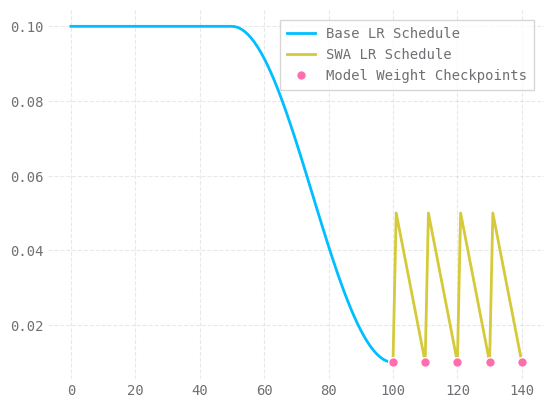

In [148]:
model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

constant = torch.optim.lr_scheduler.ConstantLR(
    optimizer, factor=1.0, total_iters=50)
decay = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=50, eta_min=0.01)
cyclic = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.05, step_size_up=1, step_size_down=9)
scheduler = torch.optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[constant, decay, cyclic], milestones=[50, 100])

lrs = []
epochs = 140

for i in range(epochs + 1):
    lrs.append(scheduler.get_last_lr())
    scheduler.step()

avg_points = [(100, 0.01), (110, 0.01)]
plt.plot(range(0, 100), lrs[:100], label="Base LR Schedule")
plt.plot(range(100, 141), lrs[100:141], label="SWA LR Schedule")
plt.plot(range(100,141,10), [0.01]*5, 'o', label="Model Weight Checkpoints")
plt.legend()
plt.show()